In [1]:
import os

# Dataset root path
data_dir = '/kaggle/input/ptb-xl-a-large-scale-ecg/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3'

# List to store all file paths
all_files = []

# Walk through every folder and subfolder
for root, dirs, files in os.walk(data_dir):
    for f in files:
        file_path = os.path.join(root, f)
        all_files.append(file_path)

# Show total number of files
print(f"✅ Total files found: {len(all_files)}")

# Show a few sample file paths
print("\n📂 Example file paths:")
for i, path in enumerate(all_files[:15]):
    print(f"{i+1}. {path}")

# Optional: summary by folder (robust version)
folder_summary = {}
for f in all_files:
    relative_path = os.path.dirname(f).replace(data_dir, '').strip(os.sep)
    parts = relative_path.split(os.sep)
    folder = parts[0] if len(parts) > 0 and parts[0] != '' else "root"
    folder_summary[folder] = folder_summary.get(folder, 0) + 1

print("\n📊 File count by top-level folder:")
for k, v in folder_summary.items():
    print(f"{k:20s} : {v}")

✅ Total files found: 87204

📂 Example file paths:
1. /kaggle/input/ptb-xl-a-large-scale-ecg/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/SHA256SUMS.txt
2. /kaggle/input/ptb-xl-a-large-scale-ecg/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/RECORDS
3. /kaggle/input/ptb-xl-a-large-scale-ecg/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/example_physionet.py
4. /kaggle/input/ptb-xl-a-large-scale-ecg/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/ptbxl_v103_changelog.txt
5. /kaggle/input/ptb-xl-a-large-scale-ecg/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/scp_statements.csv
6. /kaggle/input/ptb-xl-a-large-scale-ecg/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/ptbxl_database.csv
7. /kaggle/input/ptb-xl-a-large-scale-ecg/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/LICENSE.txt
8. /kaggle/input/ptb-xl-a-large-scale-ecg/ptb-xl-a-large-publ

In [2]:
# === Step 0: Install required library ===
!pip install wfdb

# === Step 1: Import libraries ===
import os
import pandas as pd
import numpy as np
import wfdb
import ast
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch

# === Step 2: Define ECG data loader ===
def load_raw_data(df, sampling_rate, path):
    """
    Load ECG signals from PTB-XL dataset.
    Returns a NumPy array of shape (n_samples, n_timesteps, n_leads)
    """
    file_col = 'filename_lr' if sampling_rate == 100 else 'filename_hr'
    data = [wfdb.rdsamp(os.path.join(path, f))[0] for f in df[file_col]]
    return np.array(data)

# === Step 3: Setup dataset path and sampling rate ===
path = '/kaggle/input/ptb-xl-a-large-scale-ecg/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/'
sampling_rate = 100  # 100 Hz

# === Step 4: Load metadata and SCP codes ===
Y = pd.read_csv(os.path.join(path, 'ptbxl_database.csv'), index_col='ecg_id')
Y['scp_codes'] = Y['scp_codes'].apply(lambda x: ast.literal_eval(x))

# === Step 5: Load ECG signal data ===
print("Loading ECG signal data...")
X = load_raw_data(Y, sampling_rate, path)
print(f"✅ Loaded {len(X)} ECG samples.")

# === Step 6: Load SCP statements and keep only diagnostic ones ===
agg_df = pd.read_csv(os.path.join(path, 'scp_statements.csv'), index_col=0)
agg_df = agg_df[agg_df['diagnostic'] == 1]  # keep only diagnostic statements

# === Step 7: Map SCP codes to diagnostic superclass ===
def aggregate_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))

Y['diagnostic_superclass'] = Y['scp_codes'].apply(aggregate_diagnostic)

# === Step 8: Keep only single-label ECGs ===
mask = Y['diagnostic_superclass'].apply(lambda x: len(x) == 1)
Y_filtered = Y[mask].copy()
X_filtered = X[mask.values]  # align signals

# === Step 9: Convert label list to string ===
Y_filtered['diagnostic_superclass'] = Y_filtered['diagnostic_superclass'].apply(lambda x: x[0])

# === Step 10: Train/Validation/Test Split (40/10/50) ===
# First split train (40%) and temp (60% = val+test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X_filtered, Y_filtered['diagnostic_superclass'],
    test_size=0.60,   # 60% reserved for val+test
    random_state=42,
    stratify=Y_filtered['diagnostic_superclass']
)

# Then split temp into validation (10%) and test (50%)
# 10% of total = 0.1 / 0.6 = 0.1667 of temp → so test_size = 0.8333 gives 50% test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.8333,  # makes final ratio ≈ 40 train / 10 val / 50 test
    random_state=42,
    stratify=y_temp
)

# === Step 11: Encode labels ===
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_val_enc   = le.transform(y_val)
y_test_enc  = le.transform(y_test)

# === Step 12: Convert to tensors for PyTorch ===
X_train_tensor = torch.tensor(np.array(X_train), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_enc, dtype=torch.long)
X_val_tensor   = torch.tensor(np.array(X_val), dtype=torch.float32)
y_val_tensor   = torch.tensor(y_val_enc, dtype=torch.long)
X_test_tensor  = torch.tensor(np.array(X_test), dtype=torch.float32)
y_test_tensor  = torch.tensor(y_test_enc, dtype=torch.long)

# === Step 13: Summary ===
print("\n✅ Split Summary:")
print(f"Train: {len(X_train)} samples ({len(X_train)/len(X_filtered):.2%})")
print(f"Validation: {len(X_val)} samples ({len(X_val)/len(X_filtered):.2%})")
print(f"Test: {len(X_test)} samples ({len(X_test)/len(X_filtered):.2%})")

print("\n📊 Label distribution:")
print("Train:\n", pd.Series(y_train).value_counts(), "\n")
print("Validation:\n", pd.Series(y_val).value_counts(), "\n")
print("Test:\n", pd.Series(y_test).value_counts())

print("\n✅ Tensors ready for training:")
print(f"X_train: {X_train_tensor.shape}, y_train: {y_train_tensor.shape}")
print(f"X_val: {X_val_tensor.shape}, y_val: {y_val_tensor.shape}")
print(f"X_test: {X_test_tensor.shape}, y_test: {y_test_tensor.shape}")


Loading ECG signal data...
✅ Loaded 21799 ECG samples.

✅ Split Summary:
Train: 6497 samples (40.00%)
Validation: 1624 samples (10.00%)
Test: 8123 samples (50.01%)

📊 Label distribution:
Train:
 diagnostic_superclass
NORM    3627
MI      1013
STTC     960
CD       683
HYP      214
Name: count, dtype: int64 

Validation:
 diagnostic_superclass
NORM    907
MI      253
STTC    240
CD      171
HYP      53
Name: count, dtype: int64 

Test:
 diagnostic_superclass
NORM    4535
MI      1266
STTC    1200
CD       854
HYP      268
Name: count, dtype: int64

✅ Tensors ready for training:
X_train: torch.Size([6497, 1000, 12]), y_train: torch.Size([6497])
X_val: torch.Size([1624, 1000, 12]), y_val: torch.Size([1624])
X_test: torch.Size([8123, 1000, 12]), y_test: torch.Size([8123])


/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

✅ Data split: Train 40.00%, Val 10.00%, Test 50.01%
Model Params: 0.17M | GFLOPs per inference: 0.054
Epoch 1/50 | Train Loss: 0.9603 | Val Loss: 0.7579 | Val Acc: 72.72%
Epoch 2/50 | Train Loss: 0.7456 | Val Loss: 0.6867 | Val Acc: 75.06%
Epoch 3/50 | Train Loss: 0.6877 | Val Loss: 1.0215 | Val Acc: 58.81%
Epoch 4/50 | Train Loss: 0.6488 | Val Loss: 0.6814 | Val Acc: 76.17%
Epoch 5/50 | Train Loss: 0.6261 | Val Loss: 0.6325 | Val Acc: 78.20%
Epoch 6/50 | Train Loss: 0.6052 | Val Loss: 0.6250 | Val Acc: 78.20%
Epoch 7/50 | Train Loss: 0.5828 | Val Loss: 0.6817 | Val Acc: 76.17%
Epoch 8/50 | Train Loss: 0.5624 | Val Loss: 0.6465 | Val Acc: 78.33%
Epoch 9/50 | Train Loss: 0.5424 | Val Loss: 0.6410 | Val Acc: 76.66%
Epoch 10/50 | Train Loss: 0.5459 | Val Loss: 0.6118 | Val Acc: 78.26%
Epoch 11/50 | Train Loss: 0.5198 | Val Loss: 0.7708 | Val Acc: 71.06%
Epoch 12/50 | Train Loss: 0.5079 | Val Loss: 0.6368 | Val Acc: 77.09%
Epoch 13/50 | Train Loss: 0.5144 | Val Loss: 0.7332 | Val Acc: 73.0

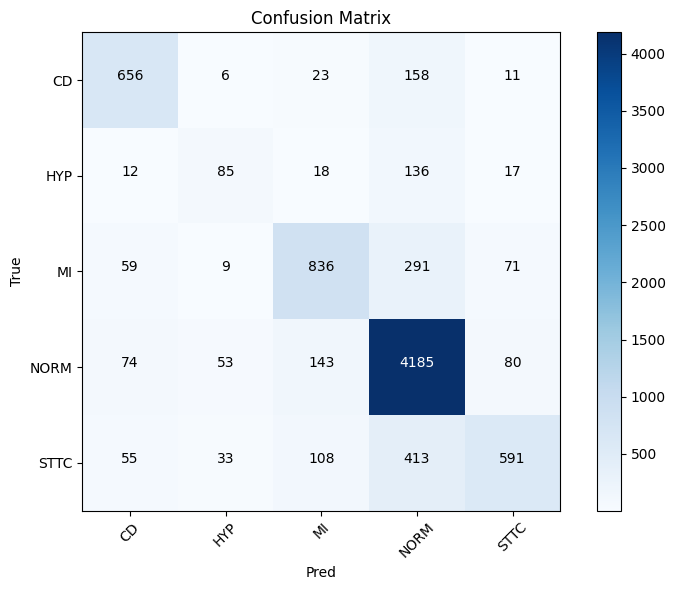

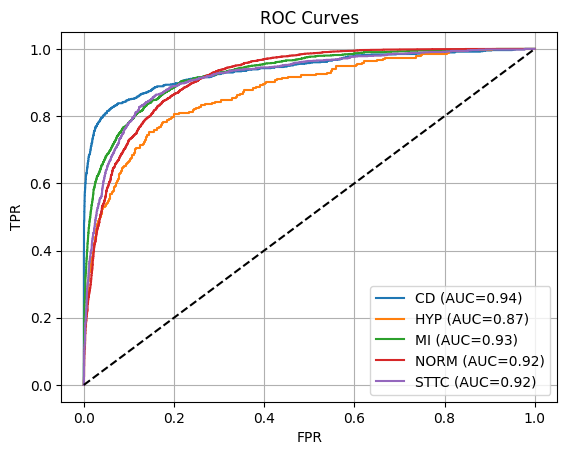

✅ Model saved at: ecgnet_outputs/ecgnet_40_10_50.pt
📁 Training stats saved at: ecgnet_outputs/training_epoch_stats_40_10_50.csv


In [3]:
# ==========================
# ECGNet: Full Training + Evaluation (40/10/50 Split)
# ==========================
!pip install ptflops --quiet

import os
import time
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_curve, auc
)

from ptflops import get_model_complexity_info

# ==========================
# 1️⃣ Data Preparation (40% train, 10% val, 50% test)
# ==========================
X = X_filtered
y = Y_filtered['diagnostic_superclass']

# Step 1: 40% train, 60% temp
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    test_size=0.60,
    random_state=42,
    stratify=y
)

# Step 2: 10% val, 50% test (1/6 val, 5/6 test)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=5/6,
    random_state=42,
    stratify=y_temp
)

print(f"✅ Data split: Train {len(X_train)/len(X):.2%}, "
      f"Val {len(X_val)/len(X):.2%}, "
      f"Test {len(X_test)/len(X):.2%}")

# Fix shape for Conv1D input: (batch, channels, seq_len)
X_train_cnn = np.transpose(np.array(X_train), (0, 2, 1))
X_val_cnn   = np.transpose(np.array(X_val), (0, 2, 1))
X_test_cnn  = np.transpose(np.array(X_test), (0, 2, 1))

# Encode labels
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_val_enc   = le.transform(y_val)
y_test_enc  = le.transform(y_test)

# Convert to tensors
X_train_tensor = torch.tensor(X_train_cnn, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_enc, dtype=torch.long)
X_val_tensor   = torch.tensor(X_val_cnn, dtype=torch.float32)
y_val_tensor   = torch.tensor(y_val_enc, dtype=torch.long)
X_test_tensor  = torch.tensor(X_test_cnn, dtype=torch.float32)
y_test_tensor  = torch.tensor(y_test_enc, dtype=torch.long)

# DataLoaders
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=64, shuffle=True)
val_loader   = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=64)
test_loader  = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=64)

# ==========================
# 2️⃣ ECGNet Model Definition
# ==========================
class ECGNet(nn.Module):
    def __init__(self, n_classes):
        super(ECGNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv1d(12, 32, kernel_size=7, padding=3),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(32, 64, kernel_size=5, padding=2),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, n_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# ==========================
# 3️⃣ Model Setup
# ==========================
n_classes = len(le.classes_)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = ECGNet(n_classes=n_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# ==========================
# 4️⃣ GFLOPs Estimation
# ==========================
try:
    in_ch = X_train_tensor.shape[1]
    seq_len = X_train_tensor.shape[2]
    model_cpu = model.to('cpu')
    macs, params = get_model_complexity_info(model_cpu, (in_ch, seq_len), as_strings=False, print_per_layer_stat=False)
    gflops = (macs * 2) / 1e9
    print(f"Model Params: {params/1e6:.2f}M | GFLOPs per inference: {gflops:.3f}")
    model.to(device)
except Exception as e:
    print("GFLOPs estimation failed:", e)

# ==========================
# 5️⃣ Training Loop
# ==========================
EPOCHS = 50
train_losses, val_losses, val_accs = [], [], []

start_time = time.time()
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for Xb, yb in train_loader:
        Xb, yb = Xb.to(device), yb.to(device)
        optimizer.zero_grad()
        logits = model(Xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    correct, total, val_loss = 0, 0, 0
    with torch.no_grad():
        for Xb, yb in val_loader:
            Xb, yb = Xb.to(device), yb.to(device)
            logits = model(Xb)
            val_loss += criterion(logits, yb).item()
            preds = torch.argmax(logits, dim=1)
            correct += (preds == yb).sum().item()
            total += yb.size(0)
    avg_val_loss = val_loss / len(val_loader)
    val_acc = 100 * correct / total
    val_losses.append(avg_val_loss)
    val_accs.append(val_acc)

    print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.2f}%")

print(f"✅ Training complete in {time.time() - start_time:.2f}s")

# ==========================
# 6️⃣ Test Evaluation
# ==========================
model.eval()
all_preds, all_probs, all_labels = [], [], []
test_start = time.time()
with torch.no_grad():
    for Xb, yb in test_loader:
        Xb = Xb.to(device)
        logits = model(Xb)
        probs = torch.softmax(logits, dim=1)
        preds = torch.argmax(probs, dim=1)
        all_preds.append(preds.cpu().numpy())
        all_probs.append(probs.cpu().numpy())
        all_labels.append(yb.numpy())
test_end = time.time()

y_true = np.concatenate(all_labels)
y_pred = np.concatenate(all_preds)
y_prob = np.concatenate(all_probs)

print(f"🧠 Test Accuracy: {(y_pred==y_true).mean()*100:.2f}%")
print(f"⏱ Test Inference Time: {test_end - test_start:.2f}s")

# ==========================
# 7️⃣ Metrics, Confusion Matrix, ROC–AUC
# ==========================
print("\n📊 Classification Report:")
print(classification_report(y_true, y_pred, target_names=le.classes_))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title("Confusion Matrix"); plt.colorbar()
tick_marks = np.arange(n_classes)
plt.xticks(tick_marks, le.classes_, rotation=45)
plt.yticks(tick_marks, le.classes_)
thresh = cm.max()/2
for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j,i, format(cm[i,j],'d'), ha='center',
             color='white' if cm[i,j]>thresh else 'black')
plt.ylabel('True'); plt.xlabel('Pred'); plt.tight_layout(); plt.show()

# ROC Curves
y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
    plt.plot(fpr, tpr, label=f"{le.classes_[i]} (AUC={auc(fpr,tpr):.2f})")
plt.plot([0,1],[0,1],'k--')
plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('ROC Curves')
plt.legend(); plt.grid(True); plt.show()

# ==========================
# 8️⃣ Save Model & Outputs
# ==========================
out_dir = "ecgnet_outputs"
os.makedirs(out_dir, exist_ok=True)

model_path = os.path.join(out_dir, "ecgnet_40_10_50.pt")
torch.save(model.state_dict(), model_path)
print(f"✅ Model saved at: {model_path}")

# Save training logs
df_epochs = pd.DataFrame({
    "epoch": np.arange(1, EPOCHS+1),
    "train_loss": train_losses,
    "val_loss": val_losses,
    "val_acc_pct": val_accs
})
csv_path = os.path.join(out_dir, "training_epoch_stats_40_10_50.csv")
df_epochs.to_csv(csv_path, index=False)
print(f"📁 Training stats saved at: {csv_path}")



✅ Data Split: Train 40.00%, Val 10.00%, Test 50.01%
✅ Model Params: 1.55M | GFLOPs per inference: 0.037
Epoch 1/50 | Train Loss: 1.2841 | Val Loss: 1.2420 | Val Acc: 56.03%
Epoch 2/50 | Train Loss: 1.1458 | Val Loss: 1.2344 | Val Acc: 56.53%
Epoch 3/50 | Train Loss: 0.9308 | Val Loss: 1.3028 | Val Acc: 52.46%
Epoch 4/50 | Train Loss: 0.6086 | Val Loss: 1.5221 | Val Acc: 48.89%
Epoch 5/50 | Train Loss: 0.3146 | Val Loss: 1.9072 | Val Acc: 48.52%
Epoch 6/50 | Train Loss: 0.1475 | Val Loss: 2.3285 | Val Acc: 44.95%
Epoch 7/50 | Train Loss: 0.0845 | Val Loss: 2.6796 | Val Acc: 50.31%
Epoch 8/50 | Train Loss: 0.0348 | Val Loss: 3.1586 | Val Acc: 49.32%
Epoch 9/50 | Train Loss: 0.0277 | Val Loss: 3.0677 | Val Acc: 48.21%
Epoch 10/50 | Train Loss: 0.0212 | Val Loss: 3.2035 | Val Acc: 48.83%
Epoch 11/50 | Train Loss: 0.0310 | Val Loss: 3.3726 | Val Acc: 47.54%
Epoch 12/50 | Train Loss: 0.0254 | Val Loss: 3.4888 | Val Acc: 47.91%
Epoch 13/50 | Train Loss: 0.0400 | Val Loss: 3.3661 | Val Acc: 47

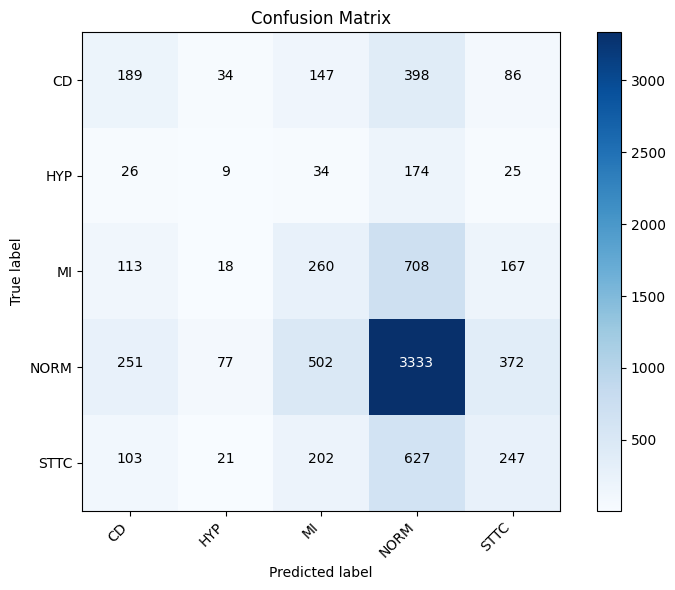

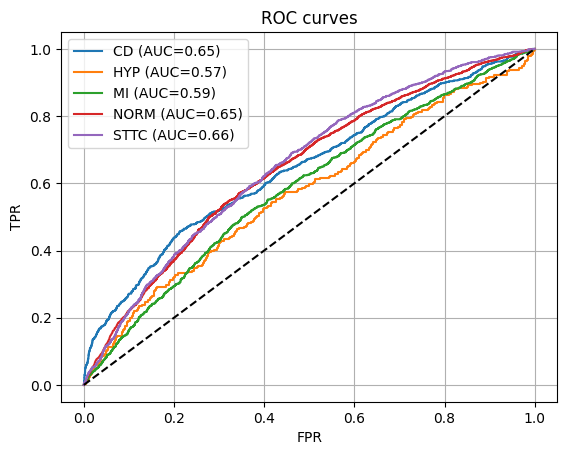

✅ Model saved as ecg_lstm_40_10_50.pt


In [4]:
# ==========================
# ECG LSTM: Full Training & Evaluation (40% train, 10% val, 50% test)
# ==========================
import os
import time
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_curve, auc
)

from ptflops import get_model_complexity_info  # GFLOPs

# ==========================
# 1️⃣ Data Preparation
# ==========================
# Assuming X_filtered (numpy array) and Y_filtered['diagnostic_superclass'] (pd.Series) exist

# Split 40% train, 10% val, 50% test
X_train, X_temp, y_train, y_temp = train_test_split(
    X_filtered, Y_filtered['diagnostic_superclass'],
    test_size=0.60,  # 60% = val+test
    random_state=42,
    stratify=Y_filtered['diagnostic_superclass']
)

# From remaining 60%, allocate 1/6 to val (10% total), 5/6 to test (50% total)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=5/6,  # 5/6 * 60% = 50%
    random_state=42,
    stratify=y_temp
)

print(f"✅ Data Split: Train {len(X_train)/len(X_filtered):.2%}, "
      f"Val {len(X_val)/len(X_filtered):.2%}, "
      f"Test {len(X_test)/len(X_filtered):.2%}")

# LSTM expects (batch, seq_len, features)
X_train_lstm = np.transpose(np.array(X_train), (0, 2, 1))
X_val_lstm   = np.transpose(np.array(X_val), (0, 2, 1))
X_test_lstm  = np.transpose(np.array(X_test), (0, 2, 1))

# Encode labels
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_val_enc   = le.transform(y_val)
y_test_enc  = le.transform(y_test)

# Convert to tensors
X_train_tensor = torch.tensor(X_train_lstm, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_enc, dtype=torch.long)
X_val_tensor   = torch.tensor(X_val_lstm, dtype=torch.float32)
y_val_tensor   = torch.tensor(y_val_enc, dtype=torch.long)
X_test_tensor  = torch.tensor(X_test_lstm, dtype=torch.float32)
y_test_tensor  = torch.tensor(y_test_enc, dtype=torch.long)

# Datasets & DataLoaders
train_ds = TensorDataset(X_train_tensor, y_train_tensor)
val_ds   = TensorDataset(X_val_tensor, y_val_tensor)
test_ds  = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=64)
test_loader  = DataLoader(test_ds, batch_size=64)

# ==========================
# 2️⃣ LSTM Model
# ==========================
class ECG_LSTM(nn.Module):
    def __init__(self, input_size=12, hidden_size=128, num_layers=2, n_classes=5, dropout=0.3):
        super(ECG_LSTM, self).__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout,
            bidirectional=True
        )
        self.fc = nn.Linear(hidden_size * 2, n_classes)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # last timestep
        out = self.fc(out)
        return out

# ==========================
# 3️⃣ Training Setup
# ==========================
n_classes = len(le.classes_)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = ECG_LSTM(input_size=X_train_tensor.shape[2], n_classes=n_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# ==========================
# 4️⃣ GFLOPs estimation
# ==========================
try:
    macs, params = get_model_complexity_info(
        model, 
        (X_train_tensor.shape[1], X_train_tensor.shape[2]),
        as_strings=False,
        print_per_layer_stat=False
    )
    gflops = (macs * 2) / 1e9
    print(f"✅ Model Params: {params/1e6:.2f}M | GFLOPs per inference: {gflops:.3f}")
except Exception as e:
    print("⚠️ GFLOPs calculation skipped:", e)

# ==========================
# 5️⃣ Training Loop
# ==========================
EPOCHS = 50
train_losses, val_losses, val_accs = [], [], []

train_start_time = time.time()
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for Xb, yb in train_loader:
        Xb, yb = Xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(Xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    correct, total = 0, 0
    val_loss = 0
    with torch.no_grad():
        for Xb, yb in val_loader:
            Xb, yb = Xb.to(device), yb.to(device)
            logits = model(Xb)
            loss = criterion(logits, yb)
            val_loss += loss.item()
            predicted = torch.argmax(logits, dim=1)
            correct += (predicted == yb).sum().item()
            total += yb.size(0)
    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = 100.0 * correct / total
    val_losses.append(avg_val_loss)
    val_accs.append(val_accuracy)

    print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {avg_train_loss:.4f} | "
          f"Val Loss: {avg_val_loss:.4f} | Val Acc: {val_accuracy:.2f}%")
train_end_time = time.time()
train_time = train_end_time - train_start_time
print(f"\nTraining completed in {train_time:.2f}s")

# ==========================
# 6️⃣ Test Evaluation
# ==========================
model.eval()
y_true, y_pred, y_prob = [], [], []

test_start_time = time.time()
with torch.no_grad():
    for Xb, yb in test_loader:
        Xb = Xb.to(device)
        logits = model(Xb)
        probs = torch.softmax(logits, dim=1)
        preds = torch.argmax(logits, dim=1)
        y_true.extend(yb.numpy())
        y_pred.extend(preds.cpu().numpy())
        y_prob.extend(probs.cpu().numpy())
test_end_time = time.time()
test_time = test_end_time - test_start_time
y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_prob = np.array(y_prob)

print(f"\n✅ Test Accuracy: {(y_pred==y_true).mean()*100:.2f}%")
print(f"Test wall-clock time: {test_time:.2f}s ({test_time/len(y_true):.6f}s per sample)")

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=le.classes_))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(n_classes)
plt.xticks(tick_marks, le.classes_, rotation=45, ha='right')
plt.yticks(tick_marks, le.classes_)
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment='center',
             color='white' if cm[i, j] > thresh else 'black')
plt.ylabel('True label'); plt.xlabel('Predicted label'); plt.tight_layout()
plt.show()

# ROC–AUC curves (one-vs-rest)
y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))
fpr, tpr, roc_auc = {}, {}, {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label=f"{le.classes_[i]} (AUC={roc_auc[i]:.2f})")
plt.plot([0,1],[0,1],'k--')
plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('ROC curves')
plt.legend(); plt.grid(True); plt.show()

# Save model
torch.save(model.state_dict(), "ecg_lstm_40_10_50.pt")
print("✅ Model saved as ecg_lstm_40_10_50.pt")



✅ Data Split: Train 40.00%, Val 10.00%, Test 50.01%
✅ Model Params: 15.97M | GFLOPs per inference: 1.600
Epoch 1/50 | Train Loss: 1.1330 | Val Loss: 1.3831 | Val Acc: 64.35%
Epoch 2/50 | Train Loss: 0.8251 | Val Loss: 1.4465 | Val Acc: 72.78%
Epoch 3/50 | Train Loss: 0.7594 | Val Loss: 0.8270 | Val Acc: 73.34%
Epoch 4/50 | Train Loss: 0.6973 | Val Loss: 0.7581 | Val Acc: 74.82%
Epoch 5/50 | Train Loss: 0.6724 | Val Loss: 1.0863 | Val Acc: 65.64%
Epoch 6/50 | Train Loss: 0.6412 | Val Loss: 0.8951 | Val Acc: 74.45%
Epoch 7/50 | Train Loss: 0.6408 | Val Loss: 0.6925 | Val Acc: 76.11%
Epoch 8/50 | Train Loss: 0.5940 | Val Loss: 0.6470 | Val Acc: 78.08%
Epoch 9/50 | Train Loss: 0.5518 | Val Loss: 0.6337 | Val Acc: 78.69%
Epoch 10/50 | Train Loss: 0.5377 | Val Loss: 0.6971 | Val Acc: 77.09%
Epoch 11/50 | Train Loss: 0.5258 | Val Loss: 0.6688 | Val Acc: 77.40%
Epoch 12/50 | Train Loss: 0.4992 | Val Loss: 0.7119 | Val Acc: 76.72%
Epoch 13/50 | Train Loss: 0.5055 | Val Loss: 0.6612 | Val Acc: 7

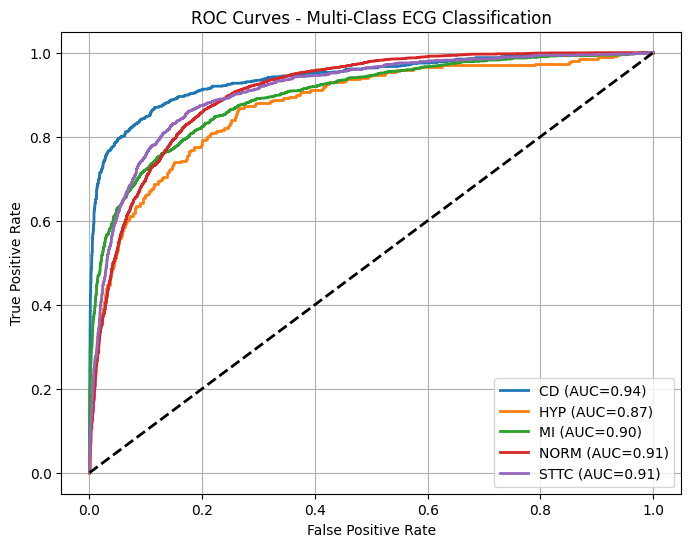


Classification Report:
              precision    recall  f1-score   support

          CD       0.75      0.76      0.75       854
         HYP       0.39      0.34      0.36       268
          MI       0.72      0.61      0.66      1266
        NORM       0.84      0.87      0.85      4535
        STTC       0.64      0.65      0.65      1200

    accuracy                           0.77      8123
   macro avg       0.67      0.65      0.65      8123
weighted avg       0.77      0.77      0.77      8123



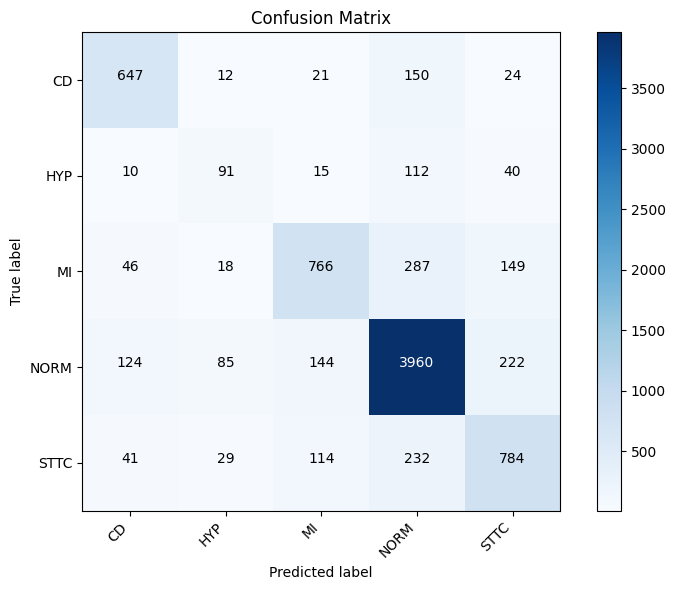

✅ Model saved as ecg_resnet50_40_10_50.pt


In [5]:
# ==========================
# ECG ResNet-50 1D: Full Training & Evaluation
# 40% Train, 10% Validation, 50% Test
# ==========================

import os
import time
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_curve, auc
)

from ptflops import get_model_complexity_info

# ==========================
# 1️⃣ Data Preparation (40/10/50 split)
# ==========================
# Assuming X_filtered: (n_samples, seq_len, n_leads)
# Assuming Y_filtered['diagnostic_superclass']: pd.Series

# Step 1: Split 40% train, 60% temp
X_train, X_temp, y_train, y_temp = train_test_split(
    X_filtered, Y_filtered['diagnostic_superclass'],
    test_size=0.60,
    random_state=42,
    stratify=Y_filtered['diagnostic_superclass']
)

# Step 2: Split temp into val 10% and test 50%
# 10/60 = 1/6 ≈ 0.1667 → validation fraction of temp
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=5/6,
    random_state=42,
    stratify=y_temp
)

print(f"✅ Data Split: Train {len(X_train)/len(X_filtered):.2%}, "
      f"Val {len(X_val)/len(X_filtered):.2%}, "
      f"Test {len(X_test)/len(X_filtered):.2%}")

# Transpose to [batch, channels, seq_len] for Conv1d
X_train = np.transpose(X_train, (0, 2, 1))
X_val   = np.transpose(X_val, (0, 2, 1))
X_test  = np.transpose(X_test, (0, 2, 1))

# Encode labels
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_val_enc   = le.transform(y_val)
y_test_enc  = le.transform(y_test)

# Convert to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_enc, dtype=torch.long)
X_val_tensor   = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor   = torch.tensor(y_val_enc, dtype=torch.long)
X_test_tensor  = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor  = torch.tensor(y_test_enc, dtype=torch.long)

# DataLoaders
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=64, shuffle=True)
val_loader   = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=64)
test_loader  = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=64)

# ==========================
# 2️⃣ 1D ResNet50 Block Definitions
# ==========================
class Bottleneck1D(nn.Module):
    expansion = 4
    def __init__(self, in_channels, planes, stride=1, downsample=None):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm1d(planes)
        self.conv2 = nn.Conv1d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm1d(planes)
        self.conv3 = nn.Conv1d(planes, planes * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm1d(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.conv3(out)
        out = self.bn3(out)
        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity
        out = self.relu(out)
        return out

class ResNet1D50(nn.Module):
    def __init__(self, n_classes, in_channels=12):
        super().__init__()
        self.inplanes = 64
        self.conv1 = nn.Conv1d(in_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm1d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)

        # ResNet50 layers
        self.layer1 = self._make_layer(64, 3)
        self.layer2 = self._make_layer(128, 4, stride=2)
        self.layer3 = self._make_layer(256, 6, stride=2)
        self.layer4 = self._make_layer(512, 3, stride=2)

        self.avgpool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(512*Bottleneck1D.expansion, n_classes)

    def _make_layer(self, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * Bottleneck1D.expansion:
            downsample = nn.Sequential(
                nn.Conv1d(self.inplanes, planes * Bottleneck1D.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm1d(planes * Bottleneck1D.expansion)
            )
        layers = [Bottleneck1D(self.inplanes, planes, stride, downsample)]
        self.inplanes = planes * Bottleneck1D.expansion
        for _ in range(1, blocks):
            layers.append(Bottleneck1D(self.inplanes, planes))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x,1)
        x = self.fc(x)
        return x

# ==========================
# 3️⃣ Model Setup
# ==========================
n_classes = len(le.classes_)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = ResNet1D50(n_classes=n_classes, in_channels=X_train_tensor.shape[1]).to(device)

# GFLOPs estimation
macs, params = get_model_complexity_info(
    model, (X_train_tensor.shape[1], X_train_tensor.shape[2]),
    as_strings=False, print_per_layer_stat=False
)
gflops = (macs*2)/1e9
print(f"✅ Model Params: {params/1e6:.2f}M | GFLOPs per inference: {gflops:.3f}")

# ==========================
# 4️⃣ Training Setup
# ==========================
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
EPOCHS = 50
train_losses, val_losses, val_accs = [], [], []

# ==========================
# 5️⃣ Training Loop
# ==========================
train_start_time = time.time()
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for Xb, yb in train_loader:
        Xb, yb = Xb.to(device), yb.to(device)
        optimizer.zero_grad()
        logits = model(Xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    val_loss = 0
    correct, total = 0, 0
    with torch.no_grad():
        for Xb, yb in val_loader:
            Xb, yb = Xb.to(device), yb.to(device)
            logits = model(Xb)
            loss = criterion(logits, yb)
            val_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            correct += (preds == yb).sum().item()
            total += yb.size(0)
    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = 100.0 * correct / total
    val_losses.append(avg_val_loss)
    val_accs.append(val_accuracy)
    print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {avg_train_loss:.4f} | "
          f"Val Loss: {avg_val_loss:.4f} | Val Acc: {val_accuracy:.2f}%")
train_end_time = time.time()
print(f"\n✅ Training completed in {train_end_time-train_start_time:.2f}s")

# ==========================
# 6️⃣ Test Evaluation
# ==========================
model.eval()
y_true, y_pred, y_prob = [], [], []
with torch.no_grad():
    for Xb, yb in test_loader:
        Xb = Xb.to(device)
        logits = model(Xb)
        probs = torch.softmax(logits, dim=1)
        preds = torch.argmax(logits, dim=1)
        y_true.extend(yb.numpy())
        y_pred.extend(preds.cpu().numpy())
        y_prob.extend(probs.cpu().numpy())
y_true, y_pred, y_prob = np.array(y_true), np.array(y_pred), np.array(y_prob)
print(f"\n✅ Test Accuracy: {(y_pred==y_true).mean()*100:.2f}%")

# ==========================
# 7️⃣ ROC & Confusion Matrix
# ==========================
# ROC
y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))
plt.figure(figsize=(8,6))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:,i], y_prob[:,i])
    roc_auc = auc(fpr,tpr)
    plt.plot(fpr,tpr,lw=2,label=f"{le.classes_[i]} (AUC={roc_auc:.2f})")
plt.plot([0,1],[0,1],'k--',lw=2)
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curves - Multi-Class ECG Classification")
plt.legend(loc="lower right"); plt.grid(True); plt.show()

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=le.classes_))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
plt.imshow(cm, cmap='Blues', interpolation='nearest')
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(n_classes)
plt.xticks(tick_marks, le.classes_, rotation=45, ha='right')
plt.yticks(tick_marks, le.classes_)
thresh = cm.max()/2.
for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j,i,cm[i,j],ha='center',color='white' if cm[i,j]>thresh else 'black')
plt.ylabel('True label'); plt.xlabel('Predicted label'); plt.tight_layout(); plt.show()

# ==========================
# 8️⃣ Save Model
# ==========================
torch.save(model.state_dict(), "ecg_resnet50_40_10_50.pt")
print("✅ Model saved as ecg_resnet50_40_10_50.pt")


✅ Data Split: Train 40.00%, Val 10.00%, Test 50.01%
✅ Model Params: 0.14M | GFLOPs per inference: 0.271
Epoch 1/50 | Train Loss: 1.2623 | Val Loss: 1.2516 | Val Acc: 55.85%
Epoch 2/50 | Train Loss: 1.2486 | Val Loss: 1.2543 | Val Acc: 55.85%
Epoch 3/50 | Train Loss: 1.2462 | Val Loss: 1.2464 | Val Acc: 55.91%
Epoch 4/50 | Train Loss: 1.2626 | Val Loss: 1.2907 | Val Acc: 54.80%
Epoch 5/50 | Train Loss: 1.2685 | Val Loss: 1.2531 | Val Acc: 56.03%
Epoch 6/50 | Train Loss: 1.2560 | Val Loss: 1.2556 | Val Acc: 56.10%
Epoch 7/50 | Train Loss: 1.2544 | Val Loss: 1.2491 | Val Acc: 56.03%
Epoch 8/50 | Train Loss: 1.2545 | Val Loss: 1.2458 | Val Acc: 56.03%
Epoch 9/50 | Train Loss: 1.2503 | Val Loss: 1.2482 | Val Acc: 56.03%
Epoch 10/50 | Train Loss: 1.2484 | Val Loss: 1.2470 | Val Acc: 56.10%
Epoch 11/50 | Train Loss: 1.2522 | Val Loss: 1.2445 | Val Acc: 55.79%
Epoch 12/50 | Train Loss: 1.2474 | Val Loss: 1.2476 | Val Acc: 56.16%
Epoch 13/50 | Train Loss: 1.2470 | Val Loss: 1.2391 | Val Acc: 56

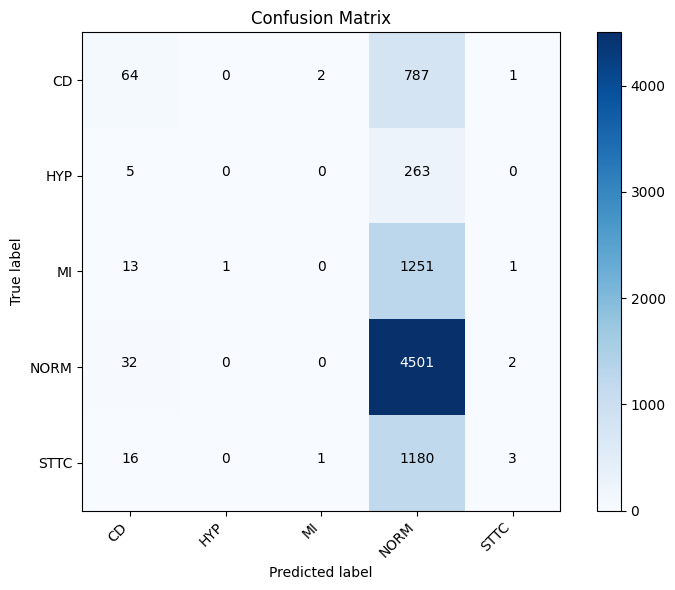

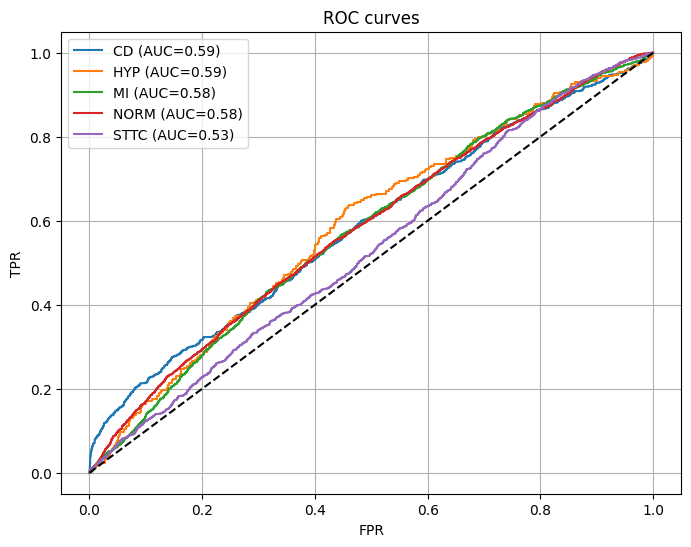

✅ Model saved as ecg_rnn_40_10_50.pt


In [6]:
# ==========================
# ECG RNN: Full Training & Evaluation
# 40% Train | 10% Val | 50% Test
# ==========================
import os
import time
import itertools
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

from ptflops import get_model_complexity_info

# ==========================
# 1️⃣ Data Preparation
# ==========================
# X_filtered: (n_samples, seq_len, n_leads)
# Y_filtered['diagnostic_superclass']: pd.Series

# Split 40% train, 60% temp
X_train, X_temp, y_train, y_temp = train_test_split(
    X_filtered, Y_filtered['diagnostic_superclass'],
    test_size=0.60,
    random_state=42,
    stratify=Y_filtered['diagnostic_superclass']
)

# Split temp: 1/6 val (~10%), 5/6 test (~50%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=5/6,
    random_state=42,
    stratify=y_temp
)

print(f"✅ Data Split: Train {len(X_train)/len(X_filtered):.2%}, "
      f"Val {len(X_val)/len(X_filtered):.2%}, "
      f"Test {len(X_test)/len(X_filtered):.2%}")

# RNN expects (batch, seq_len, features)
X_train_rnn = np.array(X_train)
X_val_rnn   = np.array(X_val)
X_test_rnn  = np.array(X_test)

# Encode labels
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_val_enc   = le.transform(y_val)
y_test_enc  = le.transform(y_test)

# Convert to tensors
X_train_tensor = torch.tensor(X_train_rnn, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_enc, dtype=torch.long)
X_val_tensor   = torch.tensor(X_val_rnn, dtype=torch.float32)
y_val_tensor   = torch.tensor(y_val_enc, dtype=torch.long)
X_test_tensor  = torch.tensor(X_test_rnn, dtype=torch.float32)
y_test_tensor  = torch.tensor(y_test_enc, dtype=torch.long)

# DataLoaders
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=64, shuffle=True)
val_loader   = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=64)
test_loader  = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=64)

# ==========================
# 2️⃣ RNN Model
# ==========================
class ECG_RNN(nn.Module):
    def __init__(self, input_size=12, hidden_size=128, num_layers=2, n_classes=5, dropout=0.3):
        super(ECG_RNN, self).__init__()
        self.rnn = nn.RNN(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            nonlinearity='tanh',
            dropout=dropout,
            bidirectional=True
        )
        self.fc = nn.Linear(hidden_size * 2, n_classes)  # bidirectional

    def forward(self, x):
        out, _ = self.rnn(x)
        out = out[:, -1, :]  # last timestep
        out = self.fc(out)
        return out

n_classes = len(le.classes_)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = ECG_RNN(input_size=X_train_tensor.shape[2], n_classes=n_classes).to(device)

# Loss & optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# ==========================
# 3️⃣ GFLOPs estimation
# ==========================
try:
    macs, params = get_model_complexity_info(
        model,
        (X_train_tensor.shape[1], X_train_tensor.shape[2]),  # (seq_len, features)
        as_strings=False,
        print_per_layer_stat=False
    )
    gflops = (macs * 2) / 1e9
    print(f"✅ Model Params: {params/1e6:.2f}M | GFLOPs per inference: {gflops:.3f}")
except Exception as e:
    print("⚠️ GFLOPs calculation skipped:", e)

# ==========================
# 4️⃣ Training Loop
# ==========================
EPOCHS = 50
train_losses, val_losses, val_accs = [], [], []

train_start_time = time.time()
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for Xb, yb in train_loader:
        Xb, yb = Xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(Xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    correct, total = 0, 0
    val_loss = 0
    with torch.no_grad():
        for Xb, yb in val_loader:
            Xb, yb = Xb.to(device), yb.to(device)
            logits = model(Xb)
            loss = criterion(logits, yb)
            val_loss += loss.item()
            predicted = torch.argmax(logits, dim=1)
            correct += (predicted == yb).sum().item()
            total += yb.size(0)
    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = 100.0 * correct / total
    val_losses.append(avg_val_loss)
    val_accs.append(val_accuracy)

    print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {avg_train_loss:.4f} | "
          f"Val Loss: {avg_val_loss:.4f} | Val Acc: {val_accuracy:.2f}%")
train_end_time = time.time()
print(f"\nTraining completed in {train_end_time - train_start_time:.2f}s")

# ==========================
# 5️⃣ Test Evaluation
# ==========================
model.eval()
y_true, y_pred, y_prob = [], [], []

with torch.no_grad():
    for Xb, yb in test_loader:
        Xb = Xb.to(device)
        logits = model(Xb)
        probs = torch.softmax(logits, dim=1)
        preds = torch.argmax(logits, dim=1)
        y_true.extend(yb.numpy())
        y_pred.extend(preds.cpu().numpy())
        y_prob.extend(probs.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_prob = np.array(y_prob)

print(f"\n✅ Test Accuracy: {(y_pred==y_true).mean()*100:.2f}%")

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=le.classes_))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(n_classes)
plt.xticks(tick_marks, le.classes_, rotation=45, ha='right')
plt.yticks(tick_marks, le.classes_)
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment='center',
             color='white' if cm[i, j] > thresh else 'black')
plt.ylabel('True label'); plt.xlabel('Predicted label'); plt.tight_layout()
plt.show()

# ROC–AUC curves
y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))
fpr, tpr, roc_auc = {}, {}, {}
plt.figure(figsize=(8,6))
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label=f"{le.classes_[i]} (AUC={roc_auc[i]:.2f})")
plt.plot([0,1],[0,1],'k--')
plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('ROC curves')
plt.legend(); plt.grid(True); plt.show()

# Save model
torch.save(model.state_dict(), "ecg_rnn_40_10_50.pt")
print("✅ Model saved as ecg_rnn_40_10_50.pt")
